In [1]:
import numpy as np
# import matplotlib.pyplot as plt
import matplotlib.pylab as plt

import tidy3d as td
import tidy3d.web as web

from tidy3d.plugins.dispersion import DispersionFitter

Output()

num_Al2O3 122230
num_SiO2 44


[17:10:40] WARNING:        warning: did not find fit with RMS error under tolerance_rms of 2.00e-02      ]8;id=918186;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\plugins\dispersion\fit.py\fit.py]8;;\:]8;id=826700;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\plugins\dispersion\fit.py#366\366]8;;\

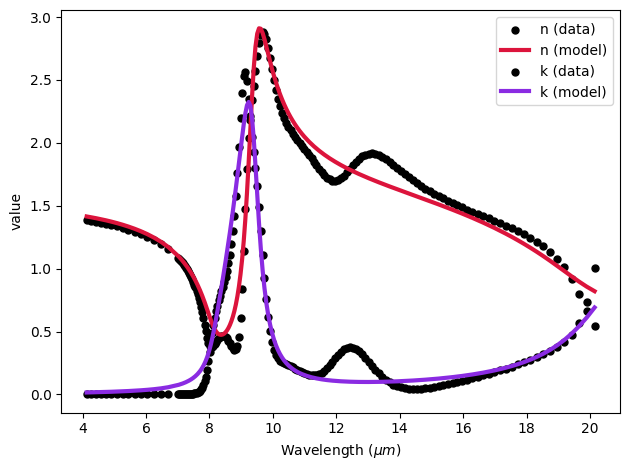

Output()

[17:11:33] WARNING:        warning: did not find fit with RMS error under tolerance_rms of 2.00e-02      ]8;id=595245;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\plugins\dispersion\fit.py\fit.py]8;;\:]8;id=956168;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\plugins\dispersion\fit.py#366\366]8;;\

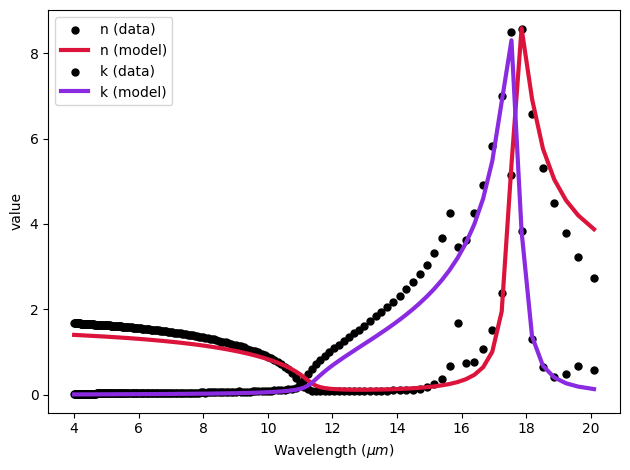

freq0: 44968868700000.0
lda0: 6.666666666666667
sim_size: (20, 20, 180)


In [2]:
# Define Paramters
# radius and location of the sphere
radius_Al2O3 = 0.25
radius_SiO2 = 4 # exp is 6um
box_size_xy = 20
box_size_z = 100

vol_Al2O3 = 4/3 * np.pi * np.power(radius_Al2O3,3)
vol_SiO2 = 4/3 * np.pi * np.power(radius_SiO2,3)
vol_box = box_size_xy * box_size_xy * box_size_z
num_Al2O3 = int(np.floor(0.2 * vol_box / vol_Al2O3))   # 20% of volumn is Al2O3
num_SiO2 = int(np.floor(0.3 * vol_box / vol_SiO2))   # 30% of volumn is SiO2
print('num_Al2O3',num_Al2O3)
print('num_SiO2',num_SiO2)

center = [0, 0, 0]

# permittivity of the Al2O3 sphere 
mat_SiO2 = "data/mat_SiO2.csv"
mat_Al2O3 = "data/mat_Al2O3.csv"

# note that additional keyword arguments to load_nk_file get passed to np.loadtxt
fitter = DispersionFitter.from_file(mat_SiO2, skiprows=1, delimiter=",")
medium_SiO2, rms_error = fitter.fit(num_poles=3, tolerance_rms=2e-2, num_tries=100)
fitter.plot(medium_SiO2)
plt.show()

fitter = DispersionFitter.from_file(mat_Al2O3, skiprows=1, delimiter=",")
medium_Al2O3, rms_error = fitter.fit(num_poles=3, tolerance_rms=2e-2, num_tries=100)
fitter.plot(medium_Al2O3)
plt.show()

# free space central wavelength
wl_start = 4  # wavelength
wl_end = 20  # wavelength
freq_start = td.C_0 / wl_end
freq_end = td.C_0 / wl_start

freqs = np.linspace(freq_start, freq_end, 100)  # freqeucny range of the simulation
freq0 = (freq_start + freq_end)/2  # central frequency
freqw = freq_end - freq_start  # width of the frequency range
print('freq0:',freq0)

lda0 = td.C_0 / freq0
print('lda0:',lda0)

# distance between the surface of the sphere and the start of the PML layers along each cartesian direction
buffer_PML = 2 * wl_end
buffer_source = 1 * wl_end

# resolution control
min_steps_per_wvl = 20

# set the domain size in x, y, and z
domain_size_xy = box_size_xy 
domain_size_z = buffer_PML + box_size_z + buffer_PML

# construct simulation size array
sim_size = (domain_size_xy, domain_size_xy, domain_size_z)
print('sim_size:',sim_size)

In [3]:
# Create random structures
geometry = []
for i in range(num_SiO2):
    position_xy = (box_size_xy - 2*radius_SiO2) * (np.random.rand(2) - 0.5) 
    position_z = (box_size_z - 2*radius_SiO2) * (np.random.rand(1) - 0.5) 
    position = [position_xy[0],position_xy[1],position_z]
    sphere = td.Structure(geometry=td.Sphere(center=position, radius=radius_SiO2), medium=medium_SiO2)
    geometry.append(sphere)
    
for i in range(num_Al2O3):
    position_xy = (box_size_xy - 2*radius_Al2O3) * (np.random.rand(2) - 0.5) 
    position_z = (box_size_z - 2*radius_Al2O3) * (np.random.rand(1) - 0.5)
    position = [position_xy[0],position_xy[1],position_z]
    sphere = td.Structure(geometry=td.Sphere(center=position, radius=radius_Al2O3), medium=medium_Al2O3)
    geometry.append(sphere)    
    
geometry = tuple(geometry)
print('Geometry Finish')

Geometry Finish


In [4]:
# add a plane wave source
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=0.5 * freqw),
    size=(td.inf, td.inf, 0),
    center=(0, 0, box_size_z/2 + buffer_source),
    direction="-",
    pol_angle=0,
)

# add a flux monitor to detect transmission
monitor_t = td.FluxMonitor(
    center=[0, 0, -box_size_z/2 - (buffer_source+buffer_PML)/2], size=[td.inf, td.inf, 0], freqs=freqs, name="T"
)

# add a flux monitor to detect reflection
monitor_r = td.FluxMonitor(
    center=[0, 0, box_size_z/2 + (buffer_source+buffer_PML)/2], size=[td.inf, td.inf, 0], freqs=freqs, name="R"
)

# add a field monitor to see the field profile at the absorption peak frequency
monitor_field = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, box_size_z], freqs=[freq0], name="field"
)

print('Source and Monitor setup Finish')

Source and Monitor setup Finish


In [5]:
run_time = 2e-11  # simulation run time

# set up simulation
sim = td.Simulation(
    size=sim_size,
#     grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lda0), # Non uniform grip
    grid_spec=td.GridSpec.uniform(dl =lda0/20),
    structures=geometry,
    sources=[plane_wave],
    monitors=[monitor_t, monitor_r, monitor_field],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
    ), 
#     boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),  # PML boundary
)  # symmetry can be used to greatly reduce the computational cost

print('Simulation setup Finish')

[17:12:11] WARNING: The medium associated with structures[0] has a frequency range:               ]8;id=246378;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=21148;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[1] has a frequency range:               ]8;id=280720;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=859975;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[2] has a frequency range:               ]8;id=654305;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=166302;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[3] has a frequency range:               ]8;id=461770;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=821348;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[4] has a frequency range:               ]8;id=66839;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=496524;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[5] has a frequency range:               ]8;id=100544;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=349312;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[6] has a frequency range:               ]8;id=694424;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=921036;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[7] has a frequency range:               ]8;id=65404;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=292292;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[8] has a frequency range:               ]8;id=92228;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=588686;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[9] has a frequency range:               ]8;id=303847;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=819592;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[10] has a frequency range:              ]8;id=127247;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=154793;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[11] has a frequency range:              ]8;id=797586;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=461365;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[12] has a frequency range:              ]8;id=263150;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=612699;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[13] has a frequency range:              ]8;id=744193;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=135136;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

[17:12:12] WARNING: The medium associated with structures[14] has a frequency range:              ]8;id=668098;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=196655;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[15] has a frequency range:              ]8;id=51132;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=243424;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[16] has a frequency range:              ]8;id=673233;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=214351;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[17] has a frequency range:              ]8;id=195480;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=778642;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[18] has a frequency range:              ]8;id=81680;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=329519;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[19] has a frequency range:              ]8;id=834605;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=478903;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[20] has a frequency range:              ]8;id=998302;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=378334;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[21] has a frequency range:              ]8;id=592264;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=698054;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[22] has a frequency range:              ]8;id=377805;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=722546;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[23] has a frequency range:              ]8;id=251161;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=968086;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[24] has a frequency range:              ]8;id=434952;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=656028;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[25] has a frequency range:              ]8;id=716301;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=416807;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[26] has a frequency range:              ]8;id=527220;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=174767;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[27] has a frequency range:              ]8;id=397163;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=730357;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[28] has a frequency range:              ]8;id=121770;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=680165;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[29] has a frequency range:              ]8;id=297750;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=594550;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[30] has a frequency range:              ]8;id=877465;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=683540;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[31] has a frequency range:              ]8;id=237062;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=862284;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[32] has a frequency range:              ]8;id=374852;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=469941;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[33] has a frequency range:              ]8;id=675447;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=593843;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[34] has a frequency range:              ]8;id=232361;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=599904;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[35] has a frequency range:              ]8;id=453657;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=629816;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[36] has a frequency range:              ]8;id=977089;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=643505;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[37] has a frequency range:              ]8;id=825841;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=313432;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[38] has a frequency range:              ]8;id=502614;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=743827;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[39] has a frequency range:              ]8;id=784568;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=657367;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[40] has a frequency range:              ]8;id=540886;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=510898;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[41] has a frequency range:              ]8;id=998099;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=241656;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[42] has a frequency range:              ]8;id=728665;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=989612;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[43] has a frequency range:              ]8;id=905664;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=47354;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

[17:12:14] WARNING: The medium associated with structures[0] has a frequency range:               ]8;id=107671;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=523955;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[1] has a frequency range:               ]8;id=72950;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=798901;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[2] has a frequency range:               ]8;id=136465;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=727838;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[3] has a frequency range:               ]8;id=975863;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=960346;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[4] has a frequency range:               ]8;id=51596;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=995819;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[5] has a frequency range:               ]8;id=563670;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=286330;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[6] has a frequency range:               ]8;id=614716;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=937047;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[7] has a frequency range:               ]8;id=959602;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=170923;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[8] has a frequency range:               ]8;id=766676;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=229722;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[9] has a frequency range:               ]8;id=836240;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=463387;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[10] has a frequency range:              ]8;id=877500;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=854318;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[11] has a frequency range:              ]8;id=29712;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=552951;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[12] has a frequency range:              ]8;id=934542;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=922850;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[13] has a frequency range:              ]8;id=185465;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=206103;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[14] has a frequency range:              ]8;id=702994;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=382244;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[15] has a frequency range:              ]8;id=24032;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=290310;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[16] has a frequency range:              ]8;id=134428;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=613001;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[17] has a frequency range:              ]8;id=626815;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=729060;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[18] has a frequency range:              ]8;id=60074;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=435768;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[19] has a frequency range:              ]8;id=122247;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=635907;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[20] has a frequency range:              ]8;id=889232;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=41963;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[21] has a frequency range:              ]8;id=653503;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=440048;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[22] has a frequency range:              ]8;id=27386;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=157021;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[23] has a frequency range:              ]8;id=873400;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=180483;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[24] has a frequency range:              ]8;id=474884;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=644618;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[25] has a frequency range:              ]8;id=508509;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=99348;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[26] has a frequency range:              ]8;id=166885;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=353467;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[27] has a frequency range:              ]8;id=991295;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=4888;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[28] has a frequency range:              ]8;id=292088;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=427559;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[29] has a frequency range:              ]8;id=478930;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=547185;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[30] has a frequency range:              ]8;id=123626;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=909666;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[31] has a frequency range:              ]8;id=382399;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=7098;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[32] has a frequency range:              ]8;id=922716;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=540420;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[33] has a frequency range:              ]8;id=977032;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=994075;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[34] has a frequency range:              ]8;id=419275;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=730515;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[35] has a frequency range:              ]8;id=179030;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=445846;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[36] has a frequency range:              ]8;id=95253;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=991489;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[37] has a frequency range:              ]8;id=889372;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=985379;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[38] has a frequency range:              ]8;id=793381;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=716995;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[39] has a frequency range:              ]8;id=263801;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=251599;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[40] has a frequency range:              ]8;id=352192;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=320972;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

[17:12:15] WARNING: The medium associated with structures[41] has a frequency range:              ]8;id=122461;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=421756;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[42] has a frequency range:              ]8;id=694612;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=511964;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[43] has a frequency range:              ]8;id=32109;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=997612;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

Simulation setup Finish


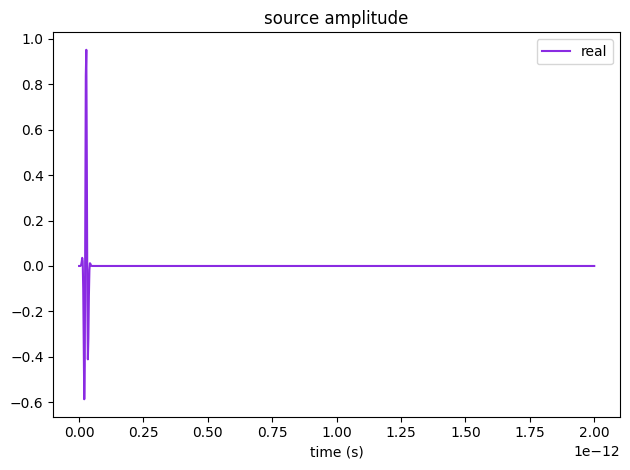

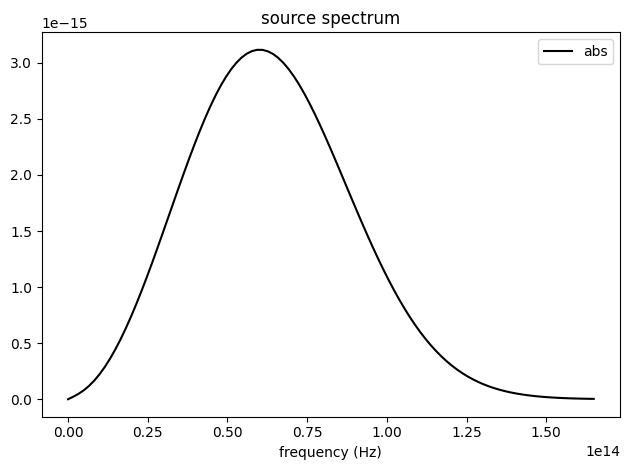

In [6]:
# Visualize source
plane_wave.source_time.plot(np.linspace(0, run_time/10, 1001))
plt.show()

plane_wave.source_time.plot_spectrum(
    times=np.linspace(0, run_time/10, 2000), val="abs"
)
plt.show()

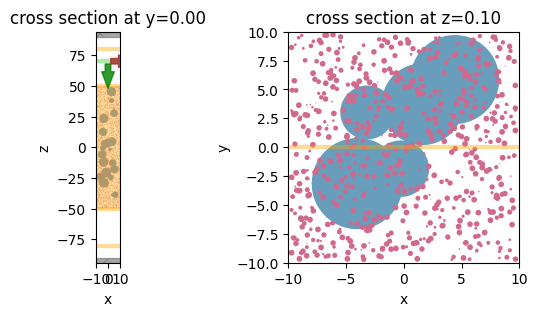

Visualize Source Finish


In [7]:
cfig, ax = plt.subplots(1, 2, figsize=(7, 3))
sim.plot(y=0, ax=ax[0])
sim.plot(z=0.1, freq=freq0, ax=ax[1])
plt.show()

print('Visualize Source Finish')

In [8]:
task_id = web.upload(sim, task_name="Simulation")
# print("Max flex unit cost: ", web.estimate_cost(task_id))

[17:12:57] Created task 'Simulation' with task_id 'fdve-8d90317f-9036-4e68-a8e1-84040aec6d34v1'.      ]8;id=282613;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=921964;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=57814;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=933751;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=733826;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d90317f-9036-4e68-a8e1-84040aec6d34v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=923669;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d90317f-9036-4e68-a8e1-84040aec6d34v1\taskId]8;;\]8;id=733826;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d90317f-9036-4e68-a8e1-84040aec6d34v1\=]8;;\]8;id=729960;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d90317f-9036-4e68-a8e1-84040aec6d34v1\fdve]8;;\]8;id=733826;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d90317f-9036-4e68-a8e1-84040aec6d34v1\-8d90317f-9036-4e68-a8e1-84040aec6d3]8;;\              
           ]8;id=733826;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d90317f-9036-4e68-a8e1-84040aec6d34v1\4v1']8;;\.                                                                                                   

Output()

In [9]:
web.start(task_id)
web.monitor(task_id, verbose=True)

import time
time.sleep(4)
print("Billed flex unit cost: ", web.real_cost(task_id))

sim_data = web.load(task_id, path="data/cooling.hdf5")

# Show the output of the log file
print(sim_data.log)

[17:14:09] status = queued                                                                            ]8;id=989273;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=952587;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#321\321]8;;\

Output()

[17:17:03] status = preprocess                                                                        ]8;id=954370;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=770953;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#315\315]8;;\

[17:25:14] Maximum FlexCredit cost: 0.067. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=779630;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=327659;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=665252;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=362269;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#342\342]8;;\

[17:25:15] running solver                                                                             ]8;id=330592;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=826629;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#352\352]8;;\

Output()

[17:25:58] early shutoff detected, exiting.                                                           ]8;id=382505;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=711000;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=220629;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=499578;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#383\383]8;;\

Output()

[17:27:47] status = success                                                                           ]8;id=688486;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=418552;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#390\390]8;;\

[17:27:52] WARNING: Billed FlexCredit for task 'fdve-8d90317f-9036-4e68-a8e1-84040aec6d34v1' is not   ]8;id=260707;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=414608;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#726\726]8;;\
           available. If the task has been successfully run, it should be available shortly.                       

Billed flex unit cost:  0.0


Output()

[17:28:17] loading SimulationData from data/cooling.hdf5                                              ]8;id=176503;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=864679;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\web\webapi.py#568\568]8;;\

[17:29:50] WARNING: The medium associated with structures[0] has a frequency range:               ]8;id=152853;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=574857;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[1] has a frequency range:               ]8;id=941563;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=777101;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[2] has a frequency range:               ]8;id=677729;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=647865;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[3] has a frequency range:               ]8;id=450668;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=176165;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[4] has a frequency range:               ]8;id=195964;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=537044;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[5] has a frequency range:               ]8;id=945620;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=775625;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[6] has a frequency range:               ]8;id=485768;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=785496;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[7] has a frequency range:               ]8;id=80104;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=966378;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[8] has a frequency range:               ]8;id=255086;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=991456;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[9] has a frequency range:               ]8;id=5053;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=94635;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[10] has a frequency range:              ]8;id=845683;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=917672;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[11] has a frequency range:              ]8;id=81859;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=679806;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[12] has a frequency range:              ]8;id=373656;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=918440;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[13] has a frequency range:              ]8;id=950274;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=308942;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[14] has a frequency range:              ]8;id=17515;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=714138;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[15] has a frequency range:              ]8;id=901310;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=586682;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[16] has a frequency range:              ]8;id=966627;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=653885;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[17] has a frequency range:              ]8;id=203311;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=544990;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[18] has a frequency range:              ]8;id=464224;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=717362;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[19] has a frequency range:              ]8;id=334148;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=671675;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[20] has a frequency range:              ]8;id=324058;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=364831;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[21] has a frequency range:              ]8;id=161184;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=421016;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[22] has a frequency range:              ]8;id=239212;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=242986;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[23] has a frequency range:              ]8;id=412547;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=617822;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

[17:29:51] WARNING: The medium associated with structures[24] has a frequency range:              ]8;id=919927;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=10743;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[25] has a frequency range:              ]8;id=735617;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=164634;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[26] has a frequency range:              ]8;id=245594;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=170845;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[27] has a frequency range:              ]8;id=522282;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=603773;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[28] has a frequency range:              ]8;id=389568;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=368413;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[29] has a frequency range:              ]8;id=871006;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=853180;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[30] has a frequency range:              ]8;id=127791;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=366498;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[31] has a frequency range:              ]8;id=140519;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=138287;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[32] has a frequency range:              ]8;id=106365;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=639669;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[33] has a frequency range:              ]8;id=24773;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=832156;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[34] has a frequency range:              ]8;id=876076;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=552772;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[35] has a frequency range:              ]8;id=552745;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=578288;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[36] has a frequency range:              ]8;id=463367;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=565877;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[37] has a frequency range:              ]8;id=286060;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=649568;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[38] has a frequency range:              ]8;id=824381;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=869357;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[39] has a frequency range:              ]8;id=683317;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=715953;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[40] has a frequency range:              ]8;id=269064;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=227146;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[41] has a frequency range:              ]8;id=894936;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=457049;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[42] has a frequency range:              ]8;id=77878;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=692853;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[43] has a frequency range:              ]8;id=65857;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=225922;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[0]. This can cause inaccuracies in the recorded results.                                    

[17:29:53] WARNING: The medium associated with structures[0] has a frequency range:               ]8;id=655447;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=266974;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[1] has a frequency range:               ]8;id=209518;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=436628;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[2] has a frequency range:               ]8;id=713381;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=808896;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[3] has a frequency range:               ]8;id=367379;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=933457;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[4] has a frequency range:               ]8;id=865476;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=984670;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[5] has a frequency range:               ]8;id=159064;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=158831;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[6] has a frequency range:               ]8;id=108872;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=181701;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[7] has a frequency range:               ]8;id=822254;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=478164;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[8] has a frequency range:               ]8;id=991083;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=994694;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[9] has a frequency range:               ]8;id=991876;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=927813;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[10] has a frequency range:              ]8;id=208981;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=203886;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[11] has a frequency range:              ]8;id=816889;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=752973;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[12] has a frequency range:              ]8;id=671539;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=569979;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[13] has a frequency range:              ]8;id=373423;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=898809;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[14] has a frequency range:              ]8;id=712010;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=612062;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[15] has a frequency range:              ]8;id=232698;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=668340;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[16] has a frequency range:              ]8;id=206745;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=18943;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[17] has a frequency range:              ]8;id=140083;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=607603;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[18] has a frequency range:              ]8;id=237605;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=211398;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[19] has a frequency range:              ]8;id=683531;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=717501;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[20] has a frequency range:              ]8;id=280679;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=567051;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[21] has a frequency range:              ]8;id=705949;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=885782;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[22] has a frequency range:              ]8;id=212866;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=337217;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[23] has a frequency range:              ]8;id=308964;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=808240;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[24] has a frequency range:              ]8;id=513762;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=525557;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[25] has a frequency range:              ]8;id=373758;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=817232;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[26] has a frequency range:              ]8;id=454941;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=544797;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[27] has a frequency range:              ]8;id=665602;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=859494;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[28] has a frequency range:              ]8;id=263184;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=606968;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[29] has a frequency range:              ]8;id=632845;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=845805;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[30] has a frequency range:              ]8;id=327199;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=956277;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[31] has a frequency range:              ]8;id=602502;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=868131;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[32] has a frequency range:              ]8;id=289888;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=933354;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[33] has a frequency range:              ]8;id=742327;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=825261;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[34] has a frequency range:              ]8;id=294462;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=463792;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[35] has a frequency range:              ]8;id=625611;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=774827;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[36] has a frequency range:              ]8;id=351430;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=996102;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[37] has a frequency range:              ]8;id=572354;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=898654;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[38] has a frequency range:              ]8;id=787503;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=525654;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[39] has a frequency range:              ]8;id=711294;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=329695;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[40] has a frequency range:              ]8;id=503799;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=689557;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[41] has a frequency range:              ]8;id=42789;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=702747;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[42] has a frequency range:              ]8;id=416720;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=71437;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

           WARNING: The medium associated with structures[43] has a frequency range:              ]8;id=753188;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py\simulation.py]8;;\:]8;id=279158;file://C:\Users\54377\AppData\Roaming\Python\Python38\site-packages\tidy3d\components\simulation.py#554\554]8;;\
           (1.487951e+13, 7.265935e+13) (Hz) that does not fully cover the frequencies contained                   
           in monitors[1]. This can cause inaccuracies in the recorded results.                                    

Simulation domain Nx, Ny, Nz: [60, 60, 564]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 2.0376e+06.
Using subpixel averaging: True
Number of time steps: 3.1472e+04
Automatic shutoff factor: 1.00e-05
Time step (s): 6.3552e-16


Compute source modes time (s):     477.2282
Compute monitor modes time (s):    5.6969
Rest of setup time (s):            27.3148

Running solver for 31472 time steps...
- Time step     42 / time 2.67e-14s (  0 % done), field decay: 1.00e+00
- Time step   1258 / time 7.99e-13s (  4 % done), field decay: 1.94e-02
- Time step   2517 / time 1.60e-12s (  8 % done), field decay: 6.21e-04
- Time step   3776 / time 2.40e-12s ( 12 % done), field decay: 1.28e-04
- Time step   5035 / time 3.20e-12s ( 16 % done), field decay: 5.30e-05
- Time step   6294 / time 4.00e-12s ( 20 % done), field decay: 2.75e-05
- Time step   7553 / time 4.80e-12s ( 24 % done), field decay: 1.76e-05
- Time step   8812 / time 5.60e-12s ( 28 % done), field decay: 1.39e-05
- Tim

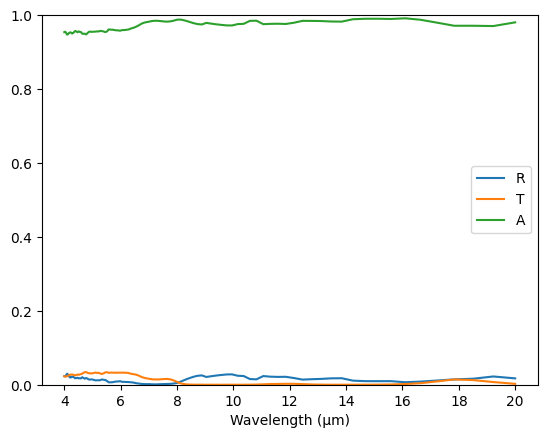

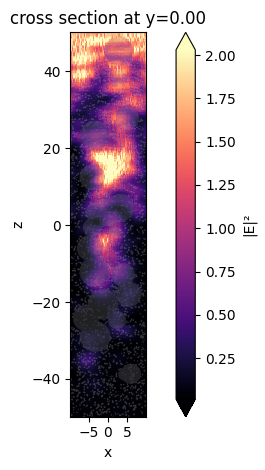

In [10]:
# Result Visualization
R = sim_data["R"].flux
T = -sim_data["T"].flux
A = 1 - R - T
plt.plot(td.C_0 /freqs, R, td.C_0 /freqs, T, td.C_0 /freqs, A)
np.savetxt('data/Abs_4-20um.txt', (np.transpose((td.C_0 /freqs, A))))

plt.xlabel("Wavelength (μm)")
plt.ylim(0, 1)
plt.legend(("R", "T", "A"))
plt.show()

sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2")
plt.show()